In [1]:
import os
import numpy as np
from pycocotools.coco import COCO
import cv2
from tqdm import tqdm

########################################################
train_all_dir = 'train_all.json'
data_dir = '/opt/ml/input/data'
########################################################

def load_json(json_dir):
    with open(json_dir) as f:
        json_file = json.load(f)
    return json_file


def get_masked_obj(image, mask, bbox):
    assert isinstance(image, np.ndarray)
    x, y, width, height = map(int, bbox)
    return cv2.bitwise_and(image,image, mask=mask)[y:y+height,x:x+width,:]


def load_image(image_dir):
    image = cv2.imread(image_dir).astype(np.float64)
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float64)
    return image 

def get_all_mask(img_id):
    image_info = coco.loadImgs(img_id)[0]
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)

    mask = np.zeros((image_info["height"], image_info["width"]))

    for ann in anns:
        cat = ann['category_id'] + 1
        _mask = coco.annToMask(ann)
        mask = np.where(_mask == 0, mask, cat)
    mask = mask.astype(np.uint8)
    return mask

def mask_to_image(mask):
    img_mask = np.zeros((512,512,3))
    for i in range(3):
        img_mask[:,:,i] = mask
    return img_mask


coco = COCO(train_all_dir)

img_ids = [(value['id'], value['file_name']) for key, value in coco.imgs.items()]

for img_id, file_name in tqdm(img_ids):
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ids=ann_ids)
    mask = get_all_mask(img_id)
    img_mask = mask_to_image(mask)
    file_name, _ = file_name.split('.')
    file_name += '.png'
    path = os.path.join(data_dir,file_name)
    cv2.imwrite(path, img_mask)   

loading annotations into memory...


  0%|          | 7/3272 [00:00<00:47, 69.47it/s]

Done (t=4.51s)
creating index...
index created!


100%|██████████| 3272/3272 [00:49<00:00, 66.55it/s] 


In [2]:
from tqdm import tqdm
pngimgs = []
for filename in tqdm(os.listdir('batch_01_vt')):
    if 'png' in filename:
        pngimgs.append((load_image(f'batch_01_vt/{filename}'), str(filename)))

100%|██████████| 2143/2143 [00:05<00:00, 362.86it/s]


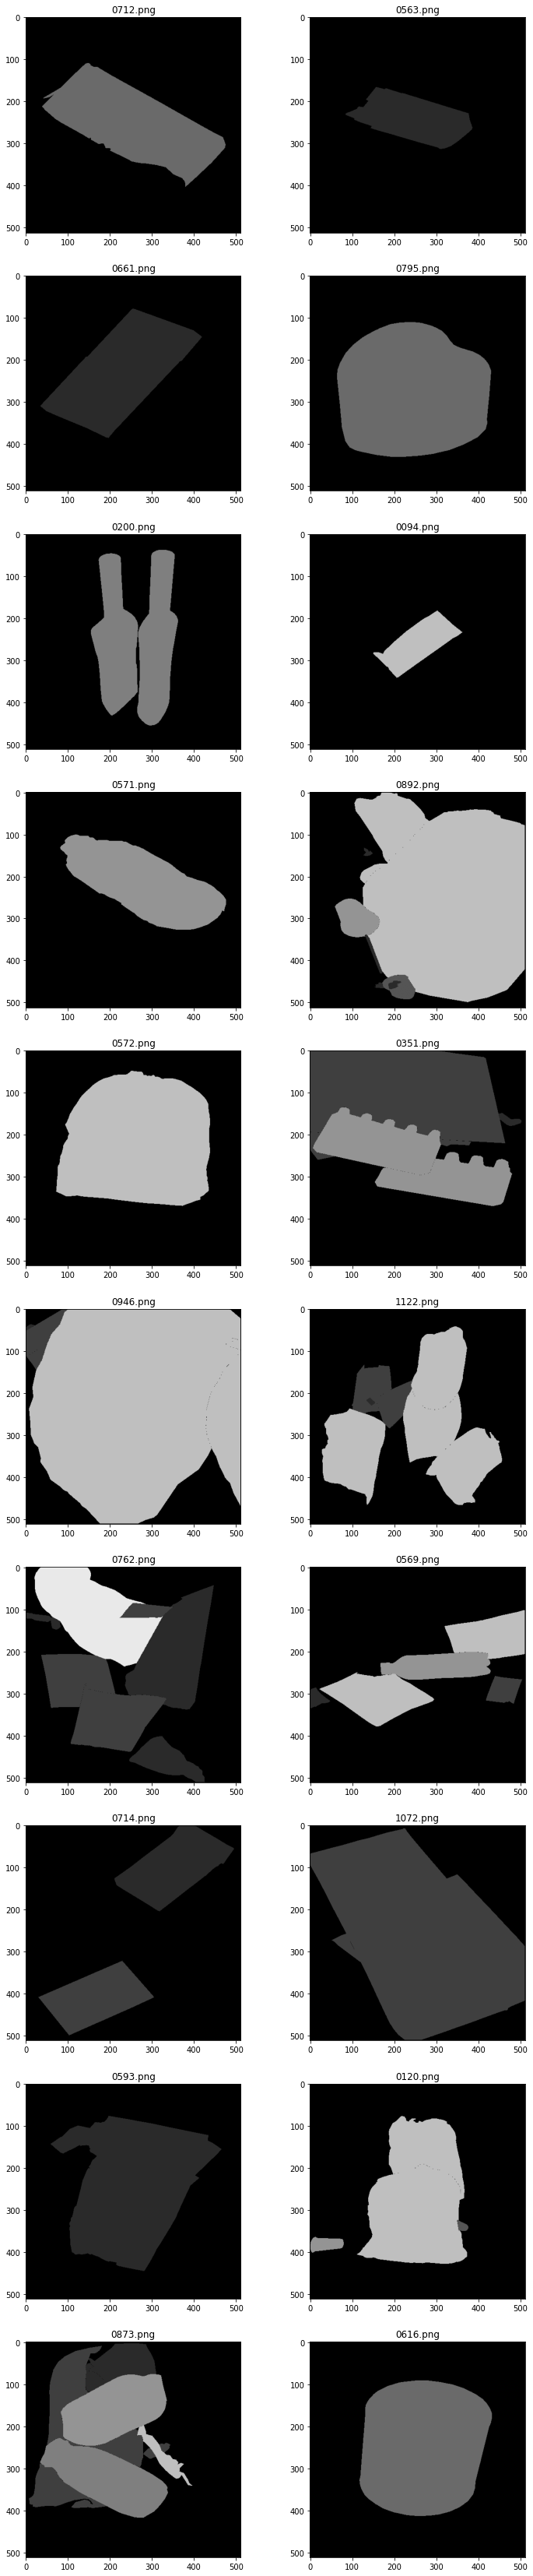

In [3]:
import matplotlib.pyplot as plt

def show_image(images, row=10, col=2):
    fig = plt.figure(figsize=(12, 60))

    idx = 1

    for r in range(1, row+1):
        for c in range(1, col+1):
            image, image_id = images[r*row+c]
            ax = fig.add_subplot(row,col,idx)
            ax.imshow(image/12)
            ax.set_title(image_id)
            idx += 1
    plt.show()

show_image(pngimgs)